In [1]:
!ls
#https://ibb.co/HhyX9Yq
#!module load tensorflow=1.15.0

Desktop    GAN.jpg	       Pictures   Untitled.ipynb  data	  ondemand
Documents  GAN_tutorial.ipynb  Public	  Videos	  foo.py
Downloads  Music	       Templates  __pycache__	  mnist


Introduction
------------

This tutorial is aimed at giving a thorough explanation of Generative Adversarial Network (GAN). First, we will understand the basic components of GAN through example where we try to generate images from random noise that looks like images from specific context. Then, we will try to design a GAN model that can generate high resolution images from low resolution images. 

In order to go through this tutorial, some basic understanding of how deep learning will be useful. Also, it would help to have a GPU. Let us begin: 

Generative Adversarial Networks
-------------------------------

What is a GAN?

GANs are a framework for teaching a DL model to capture the training data’s distribution so we can generate new data from that same distribution. GANs were invented by Ian Goodfellow in 2014 and first described in the paper 'Generative Adversarial Nets <https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf>'.

GAN belongs to the set of algorithms named *Generative models*. These algorithms belong to the *Unsupervised Learning* class, which is a paradigm of ML where the model tries to learn the underlying structure of the input data without any available ground truth. So, given input data $x$, these algorithms try to learn the distribution function of the input data $p(x)$. This also allows them to generate new instances of inputs. In contrast, in *Supervised learning*, the model tries to learn the mapping function $y' = f(x)$, where the ground truth $y$ corresponding to input $x$ is available. However, these kind of models are not allowed to generate synthetic inputs.

The basic structure of a GAN is as follows: ![](GAN.jpg)

There are two main components in a GAN:

1) *Generator* **G**: This is a model that tries to generate new data similar to the real samples. It can be thought of as similar to a human art forger who tries to forge real artworks to fake ones and tries to sell them.

2) *Discriminator* **D**: This is a model that tries to classify the input data to whether it is real or fake. More specifically, given an input data, it tries to determine whether the data is from the real samples or whether the data is generated by **G**. It can be thought of similar to a human expert who can distinguish between real artworks and artworks faked by the forger. 

During training, **G** is continuously try to fool the discriminator by generating better and better fakes, while **D** tries to become a better detective and correctly classify the real and fake samples. The training reaches its saturation level when **G** is generating perfect
fakes those look as if they came directly from the real sample, and **D** is left to always guess at 50% confidence that the generator output is real or fake.

Mathematical Modeling
----------------------

Let us define some notations for GAN which will be used throughout the tutorial.

Let $z$ be a latent space vector (which we will probably generate using some kind of distribution). 

Let $x$ represent the real input space which is visible only to **D**.


**Notations for G**:


Let $G(z,\theta_1)$ represent the model which is used as the Generator. Here, $\theta_1$ represents the set of parameters associated with **G**. For example, if **G** is a feed forward neural network, then **\theta_1** is the weights associated with its layers.

So, given the latent space $z$, the generator performs a mapping $G(z)$ using the parameters $\theta_1$, which is used as the fake samples.

**Notations for D**:

Let $D(y,\theta_2)$ represent the model which is used as the Discriminator. Similar to **G**, here, $\theta_2$ represents the set of parameters associated with **D**. 

Given any input $y$, the discriminator performs a mapping $D(y)$ using the parameters $\theta_2$. Here, $D(y) \in (0,1)$. More specifically, given an input $y$, $D(y)$ is the probability of $y$ sampled from input space $x$. This means that given a sample, **D** tries to determine whether the sample is originated from real input space $x$ or from generator **G**.

**Altogether**:

Given an input $y$, $D(y)$ should be HIGH when $y$ is sampled from the real input space $x$ and $D(y)$ should be low when $y$ is generated from **G**.

Therefore, the goal of **D** is to maximize $D(x)$ and minimize $D(G(z))$. Or, we can say that, the goal of **D** is to maximize both $D(x)$ and $1-D(G(z))$.

Whereas, the goal of **G** is to generate such fake samples $G(z)$ so that $1-D(G(z))$ is minimized. 

So, we can see that **D** and **G** is playing a minimax game here. In Goodfellow's paper, the loss function of this game is defined as:

\begin{align}\underset{G}{\text{min}} \underset{D}{\text{max}}V(D,G) = \mathbb{E}_{x\sim p_{data}(x)}\big[logD(x)\big] + \mathbb{E}_{z\sim p_{z}(z)}\big[log(1-D(G(z)))\big]\end{align}

where $p_{data}(x)$ is the distribution of real training dataset $x$ and $p_{z}(z)$ is the distribution of the latent space.

In theory, the solution to this minimax game is reached when $p_{data} = p_z$ and the discriminator guesses randomly if the inputs are real or fake. However, the convergence theory of GANs is still being actively researched and in reality models do not always train to this point.

Now that we have a basic understanding of how GAN works, let us get into the coding part. We will first import the dependencies that we will need.

In [2]:
from __future__ import print_function
import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets
import numpy as np
import matplotlib.pyplot as plt

from foo import Logger

The last package is a logger class designed by 'Diego Gomez' <https://github.com/diegoalejogm>. This will help us visualize some things that has happened during training the GAN.

**Dataset**:

For the dataset, we will be using MNIST dataset (add reference of MNIST here). MNIST training dataset consists of 60,000 black and white images of handwritten digits. The images are of size $28 \times 28$. We will load this data with some preprocessing.

First we download the dataset to a folder of our current directory.

In [3]:
mnist_trainset = datasets.MNIST(root='./mnist', train=True, download=True, transform=None)
print(mnist_trainset)


Dataset MNIST
    Number of datapoints: 60000
    Root location: ./mnist
    Split: Train


We can see that it says that there are a total of 60000 datapoints. Next, we apply normalization over it using a transformation function. We also create a dataloader for the dataset so that we can later iterate through the Dataset. Although, there was no need for the Resize transformation regarding the image size, it demonstraes how would you maybe want to resize the images to a different size.

In [4]:
image_size = 28

def get_transformed_data():
    data_dir = './mnist'
    transform=transforms.Compose([
       transforms.Resize(image_size),
       transforms.CenterCrop(image_size),
       transforms.ToTensor(),
       transforms.Normalize((0.5,), (0.5,))
    ])
    return datasets.MNIST(root=data_dir, train=True, transform = transform, download=False)

data = get_transformed_data()# Create loader with data, so that we can iterate over it
data_loader = torch.utils.data.DataLoader(data, batch_size=100, shuffle=True)
# Num batches
num_batches = len(data_loader)
print(num_batches)

600


Next, we define the models of the GAN. 

**Discriminator D**:

The job of the discriminator was to take input and return the probability of the image being generated from the real dataset. In this case, the Discriminator will take an input image of the same dimension as the dataset in MNIST and output the probability whether the image belongs to the dataset we have defined just now or whether it belongs to a different domain.

So, first things first, the first layer of the Discriminator will be a convolution layer. The convolution layer in PyTorch only need to know the number of input channels. In our case, it is 1. The number of output channel of this convolution layer is fixed 64 in this case. You can play around with it.

The rest of the network has two linear network stacked. Each linear layer will have a ReLU non-linearity activation function associated with it. The last layer has a SigMoid activation function that will generate an output within range (0,1).

(More details will be added regarding the dimensions)


In [73]:
class Discriminator(torch.nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        n_conv_channel = 32
        n_in = 32*6*6
        n_hidden_size_1 = 1024
        #n_hidden_size_2 = 512
        n_out = 1
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, n_conv_channel, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True)
        )
        self.linear1 = nn.Sequential( 
            nn.Linear(n_in, n_hidden_size_1),
            nn.ReLU(inplace=True)
        )
        self.outLayer = nn.Sequential(
            nn.Linear(n_hidden_size_1, n_out),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv1(x)
        #print(x.shape)
        x = x.view(x.size(0), 32*6*6)
        x = self.linear1(x)
        x = self.outLayer(x)
        return x
    
D = Discriminator()

We have defined the network. Let us just feed it with some random dummy inputs to see whether it produces outputs as desired and everything is well.

In [74]:
mock_input_batch = torch.zeros(10, 1, 28, 28).normal_(0, 0.02)
D.eval()
mock_output = D.forward(mock_input_batch)
D.train()
# print(mock_input_batch.shape)
# print(mock_output.shape)
# print(mock_output)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
  )
  (linear1): Sequential(
    (0): Linear(in_features=1152, out_features=1024, bias=True)
    (1): ReLU(inplace=True)
  )
  (outLayer): Sequential(
    (0): Linear(in_features=1024, out_features=1, bias=True)
    (1): Sigmoid()
  )
)

So, we can see that after feeding the discriminator with a batch of inputs, it is mapping each sample in the map to a probabilistic value in the range (0,1). So, the network is working as desired.

**Generator G**:

Similar to Discriminator **D**, we will also design the generator network **G**. Remember that the output of **G** will be fed as the input to **D**. So, the output of the generator will be an image of size $28 \times 28$ with a channel size of 1. It will also be useful for the Generator outputs to have values in the same range that we normalized the MNIST dataset into. 

The MNIST dataset had values in the range (0,1). The normalization function had a mean and std of 0.5 each. For each pixel of the image this transform performs the mapping of $pixel = (pixel - mean) / std$. So, the minimum value 0 is mapped to -1 and the maximum value 1 is mapped to +1. So, the MNIST images have a value range of $[-1,1]$. Therefore, in the generator function, we will use a tanH activation function in the last layer which also conveniently produces output in the range $[-1,1]$.

The overall structure of **G** is comprised of two deconvolution layer. As convolution layer downsamples an image, deconvolution layer upsamples an image. 
(Details of deconvolution layer will be written later)

(More details will be added regarding the dimensions)


In [84]:
n_latent_size = 100

class Generator(torch.nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        n_in = n_latent_size
        n_deconv_channel = 8
        
        self.deconv1 = nn.Sequential(
            nn.ConvTranspose2d(n_in,n_deconv_channel*2,kernel_size=11, stride=4, padding=2,bias=False),
            nn.ReLU(inplace=True)
        )
        self.deconv2 = nn.Sequential(
            nn.ConvTranspose2d(n_deconv_channel*2,n_deconv_channel,kernel_size=4, stride=2, padding=1,bias=False),
            nn.ReLU(inplace=True)
        )
        self.deconv3 = nn.Sequential(
            nn.ConvTranspose2d(n_deconv_channel,1,kernel_size=4, stride=2, padding=1,bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.deconv1(x)
        #print(x.shape)
        x = self.deconv2(x)
        #print(x.shape)
        x = self.deconv3(x)
        #print(x.shape)
        return x
    
G = Generator()

mock_input_batch = torch.zeros(10, 100, 1, 1).normal_(0, 0.02)
G.eval()
mock_output = G.forward(mock_input_batch)
G.train()
# print(mock_input_batch.shape)
print(mock_output.shape)
# #print(mock_output)
# print(torch.min(mock_output))
# print(torch.max(mock_output))

torch.Size([10, 1, 28, 28])


Note that the value of *n_latent_size* has been chosen arbitrarily. It actually represents the size of the data that will be sampled from the latent space by the Generator. You can change this value to see how the Generator learns to mimic the real input space with different such values. 

Below, we define a function that will create this random sample from the latent space and the output of this function will be fed as the input to the Generator. 

In [85]:
def get_latent_sample(size):
    return Variable(torch.randn(size, n_latent_size, 1, 1))
    

Description will be added regarding learning rate and optimizer.

In [86]:
learning_rate = 3e-4
D_optimizer = optim.Adam(D.parameters(), lr=learning_rate)
G_optimizer = optim.Adam(G.parameters(), lr=learning_rate)

Description will be added regarding binary cross entropy loss

In [87]:
loss = nn.BCELoss()

Description will be added regarding training of Discriminator

In [88]:
def train_D(optimizer, real_sample, G_sample):
    batch_size = real_sample.size(0)
    # Reset gradients
    optimizer.zero_grad()
    
    # Train on Real Data
    real_score = D(real_sample)
    # Calculate loss and backpropagate
    real_loss = loss(real_score, Variable(torch.ones(batch_size, 1)) )
    real_loss.backward()

    # Train on synthetic Data
    fake_score = D(G_sample)
    # Calculate loss and backpropagate
    fake_loss = loss(fake_score, Variable(torch.zeros(batch_size, 1)) )
    fake_loss.backward()
    
    # Update weights
    optimizer.step()
    
    return real_loss + fake_loss, real_score, fake_score
#will add some dummy test here

Description will be added regarding training of Generator

In [89]:
def train_G(optimizer, G_sample):
    batch_size = G_sample.size(0)    
    
    # Reset gradients
    optimizer.zero_grad()    
    
    # Sample noise and generate synthtetic data
    score = D(G_sample)    
    # loss and backpropagate
    G_loss = loss(score, Variable(torch.ones(batch_size, 1)))
    G_loss.backward()    
    
    # Update weights
    optimizer.step()    
    
    return G_loss
#will add some dummy test here

Description will be added regarding overall training and the logger.

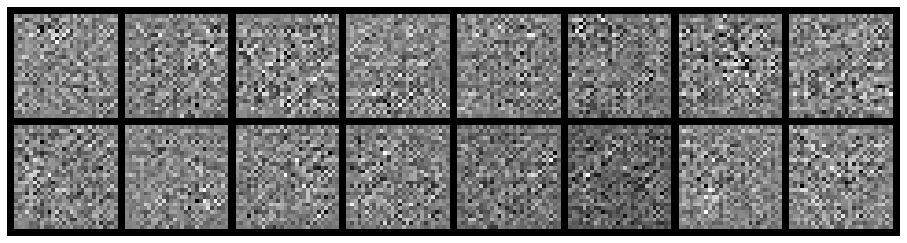

Epoch: [0/50], Batch Num: [0/600]
Discriminator Loss: 0.1456, Generator Loss: 11.9311
D(x): 0.9319, D(G(z)): 0.0000


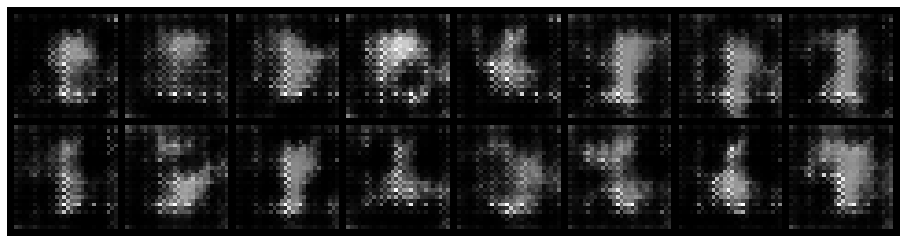

Epoch: [1/50], Batch Num: [0/600]
Discriminator Loss: 0.3688, Generator Loss: 7.8072
D(x): 1.0000, D(G(z)): 0.2132


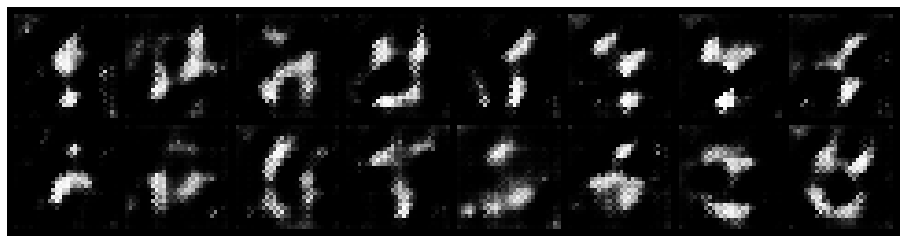

Epoch: [2/50], Batch Num: [0/600]
Discriminator Loss: 0.1203, Generator Loss: 5.3626
D(x): 0.9452, D(G(z)): 0.0224


Epoch: [3/50], Batch Num: [0/600]
Discriminator Loss: 0.1460, Generator Loss: 5.0679
D(x): 0.9432, D(G(z)): 0.0580


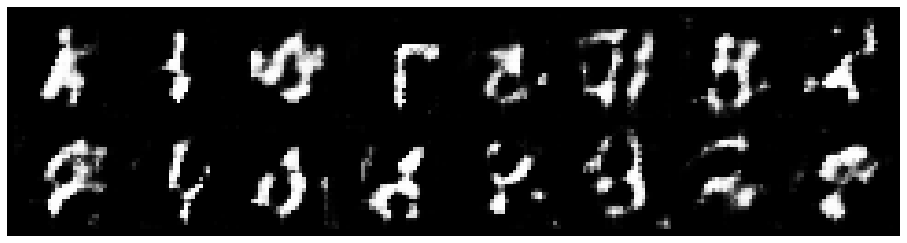

Epoch: [4/50], Batch Num: [0/600]
Discriminator Loss: 0.4035, Generator Loss: 3.4593
D(x): 0.8774, D(G(z)): 0.1295


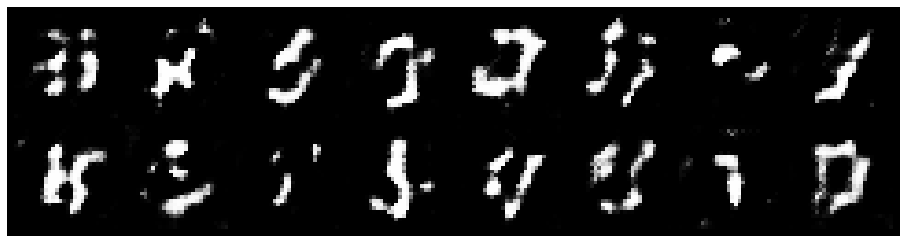

Epoch: [5/50], Batch Num: [0/600]
Discriminator Loss: 0.4846, Generator Loss: 4.2726
D(x): 0.7575, D(G(z)): 0.0942


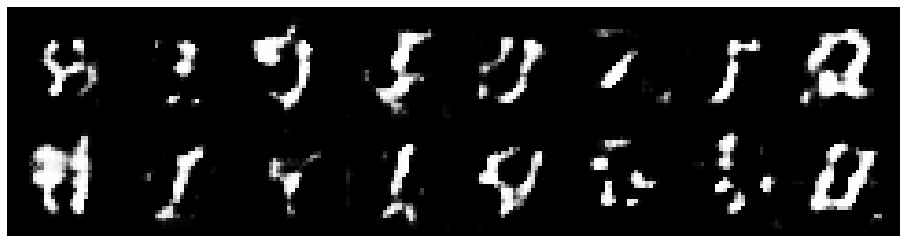

Epoch: [6/50], Batch Num: [0/600]
Discriminator Loss: 0.4276, Generator Loss: 3.0159
D(x): 0.8223, D(G(z)): 0.1076


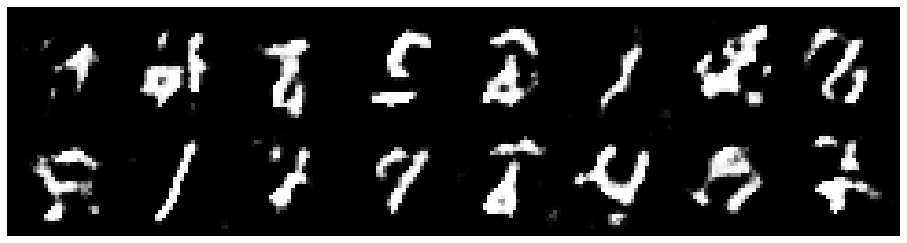

Epoch: [7/50], Batch Num: [0/600]
Discriminator Loss: 0.5856, Generator Loss: 3.3955
D(x): 0.9111, D(G(z)): 0.2777


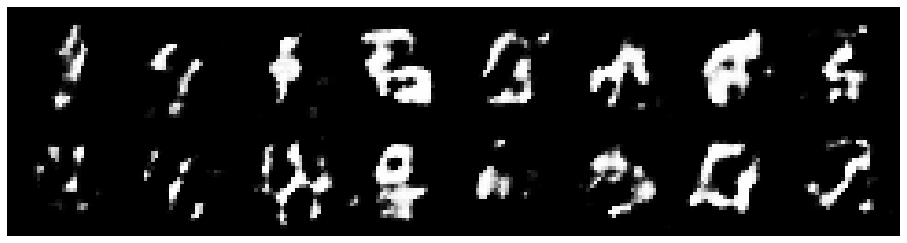

Epoch: [8/50], Batch Num: [0/600]
Discriminator Loss: 0.4598, Generator Loss: 2.9213
D(x): 0.8628, D(G(z)): 0.1822


Epoch: [9/50], Batch Num: [0/600]
Discriminator Loss: 0.5280, Generator Loss: 2.0990
D(x): 0.7600, D(G(z)): 0.1323


Epoch: [10/50], Batch Num: [0/600]
Discriminator Loss: 0.5064, Generator Loss: 2.6488
D(x): 0.8204, D(G(z)): 0.1568


Epoch: [11/50], Batch Num: [0/600]
Discriminator Loss: 0.4355, Generator Loss: 2.9685
D(x): 0.8658, D(G(z)): 0.1805


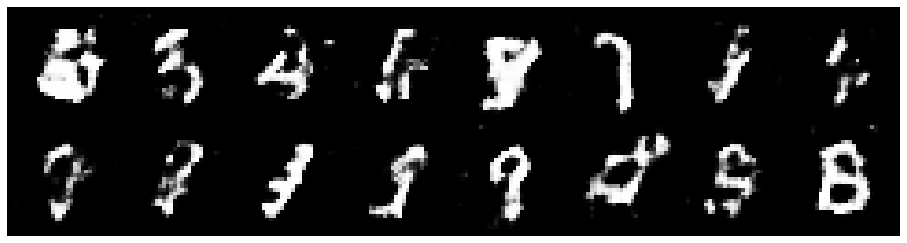

Epoch: [12/50], Batch Num: [0/600]
Discriminator Loss: 0.3692, Generator Loss: 2.3494
D(x): 0.8830, D(G(z)): 0.1428


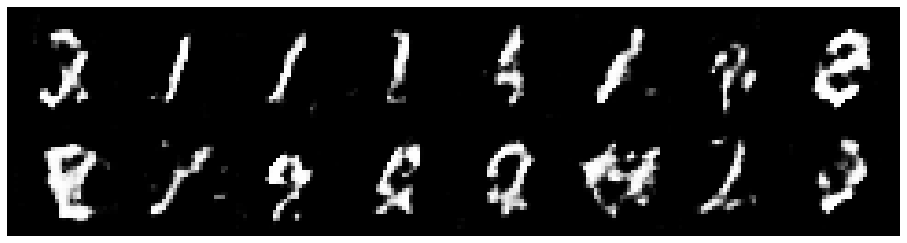

Epoch: [13/50], Batch Num: [0/600]
Discriminator Loss: 0.5388, Generator Loss: 3.8835
D(x): 0.8007, D(G(z)): 0.0999


Epoch: [14/50], Batch Num: [0/600]
Discriminator Loss: 0.3692, Generator Loss: 3.4242
D(x): 0.8403, D(G(z)): 0.0976


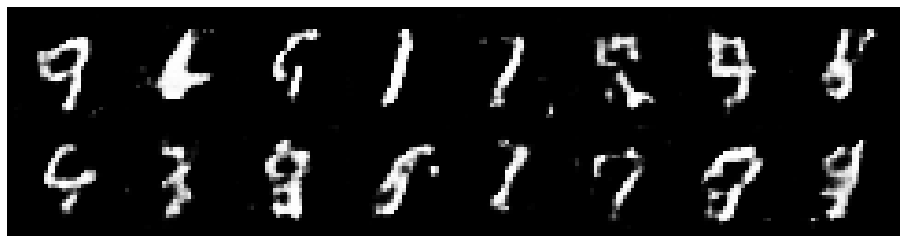

Epoch: [15/50], Batch Num: [0/600]
Discriminator Loss: 0.3842, Generator Loss: 3.2879
D(x): 0.8741, D(G(z)): 0.1282


Epoch: [16/50], Batch Num: [0/600]
Discriminator Loss: 0.4843, Generator Loss: 4.2288
D(x): 0.7752, D(G(z)): 0.0866


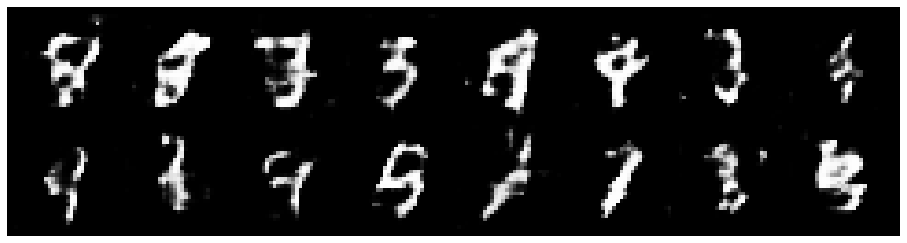

Epoch: [17/50], Batch Num: [0/600]
Discriminator Loss: 0.3382, Generator Loss: 4.2320
D(x): 0.8677, D(G(z)): 0.0803


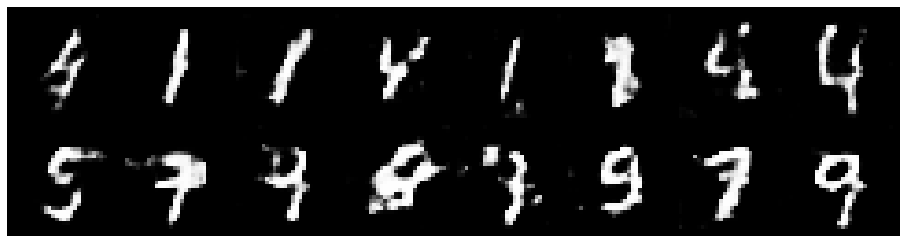

Epoch: [18/50], Batch Num: [0/600]
Discriminator Loss: 0.3143, Generator Loss: 3.1709
D(x): 0.9241, D(G(z)): 0.1406


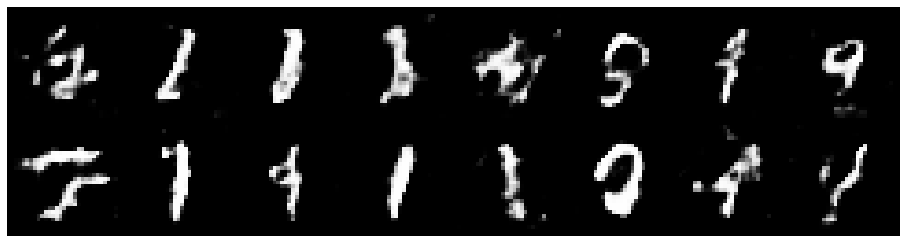

Epoch: [19/50], Batch Num: [0/600]
Discriminator Loss: 0.3054, Generator Loss: 3.7861
D(x): 0.8803, D(G(z)): 0.1000


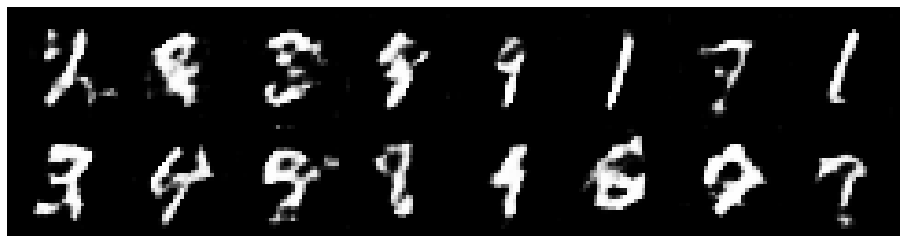

Epoch: [20/50], Batch Num: [0/600]
Discriminator Loss: 0.2552, Generator Loss: 2.9320
D(x): 0.9369, D(G(z)): 0.1380


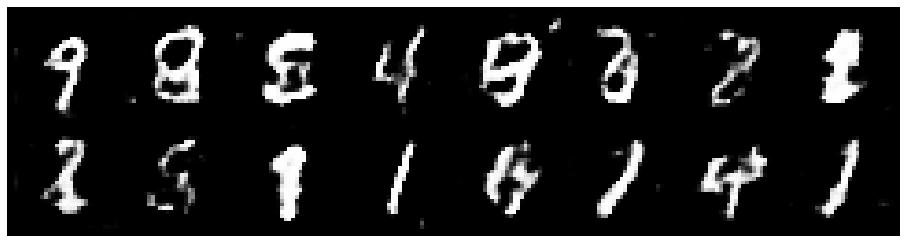

Epoch: [21/50], Batch Num: [0/600]
Discriminator Loss: 0.2821, Generator Loss: 2.8701
D(x): 0.8903, D(G(z)): 0.0850


Epoch: [22/50], Batch Num: [0/600]
Discriminator Loss: 0.2800, Generator Loss: 3.7956
D(x): 0.9020, D(G(z)): 0.1057


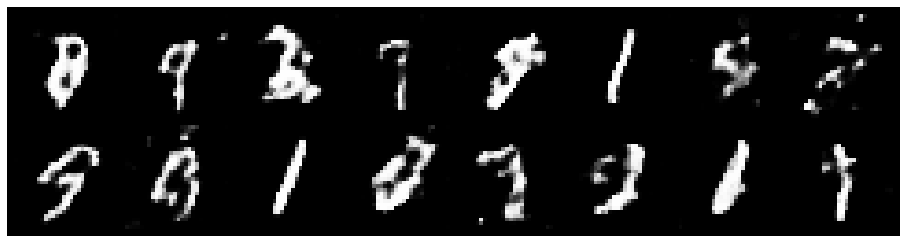

Epoch: [23/50], Batch Num: [0/600]
Discriminator Loss: 0.2374, Generator Loss: 3.9261
D(x): 0.9156, D(G(z)): 0.0919


Epoch: [24/50], Batch Num: [0/600]
Discriminator Loss: 0.2814, Generator Loss: 3.6392
D(x): 0.8831, D(G(z)): 0.0721


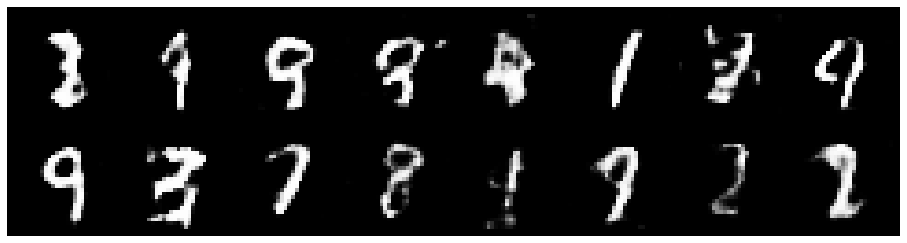

Epoch: [25/50], Batch Num: [0/600]
Discriminator Loss: 0.3630, Generator Loss: 3.6757
D(x): 0.9133, D(G(z)): 0.1622


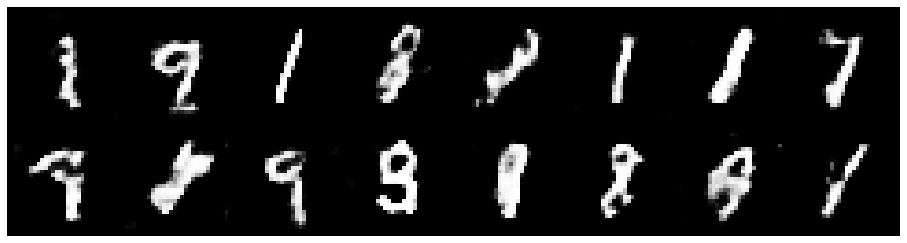

Epoch: [26/50], Batch Num: [0/600]
Discriminator Loss: 0.3235, Generator Loss: 3.3311
D(x): 0.9364, D(G(z)): 0.1463


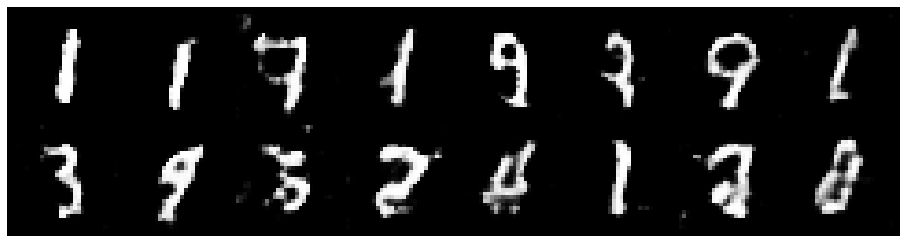

Epoch: [27/50], Batch Num: [0/600]
Discriminator Loss: 0.2414, Generator Loss: 3.5644
D(x): 0.8783, D(G(z)): 0.0591


Epoch: [28/50], Batch Num: [0/600]
Discriminator Loss: 0.2658, Generator Loss: 3.0792
D(x): 0.9490, D(G(z)): 0.1389


Epoch: [29/50], Batch Num: [0/600]
Discriminator Loss: 0.3476, Generator Loss: 4.9450
D(x): 0.8646, D(G(z)): 0.1003


Epoch: [30/50], Batch Num: [0/600]
Discriminator Loss: 0.2596, Generator Loss: 4.0269
D(x): 0.9154, D(G(z)): 0.1001


Epoch: [31/50], Batch Num: [0/600]
Discriminator Loss: 0.3407, Generator Loss: 4.2665
D(x): 0.8780, D(G(z)): 0.0868


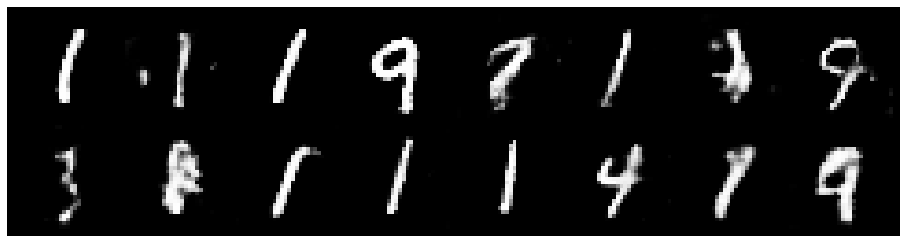

Epoch: [32/50], Batch Num: [0/600]
Discriminator Loss: 0.3364, Generator Loss: 3.9985
D(x): 0.9090, D(G(z)): 0.1147


Epoch: [33/50], Batch Num: [0/600]
Discriminator Loss: 0.4024, Generator Loss: 4.1973
D(x): 0.9488, D(G(z)): 0.1755


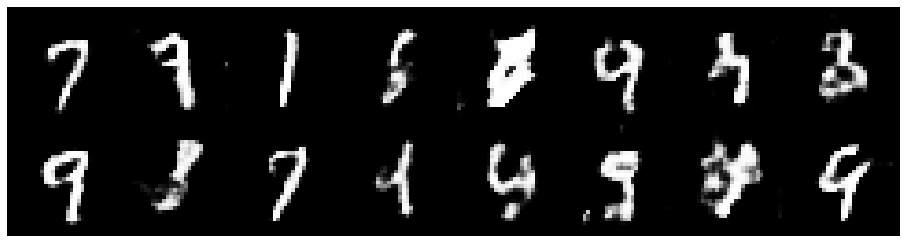

Epoch: [34/50], Batch Num: [0/600]
Discriminator Loss: 0.2002, Generator Loss: 3.8643
D(x): 0.9172, D(G(z)): 0.0748


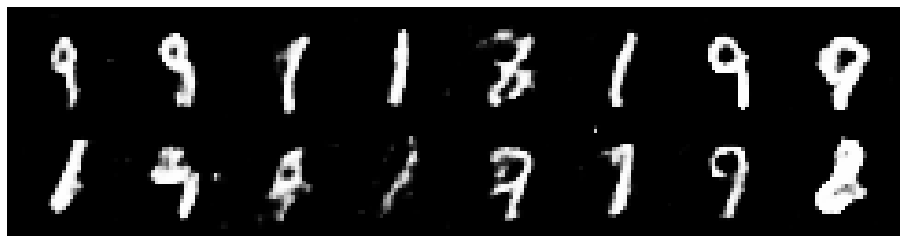

Epoch: [35/50], Batch Num: [0/600]
Discriminator Loss: 0.2588, Generator Loss: 3.9133
D(x): 0.9201, D(G(z)): 0.1002


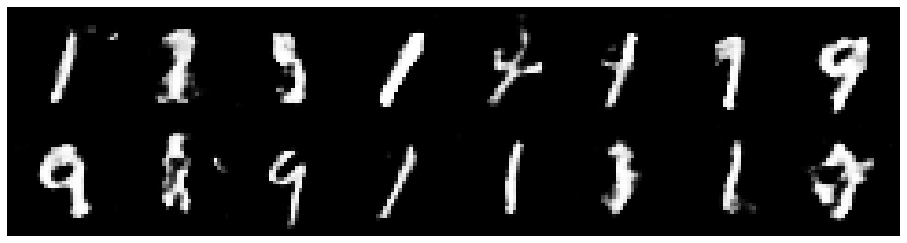

Epoch: [36/50], Batch Num: [0/600]
Discriminator Loss: 0.2991, Generator Loss: 3.4598
D(x): 0.8883, D(G(z)): 0.0900


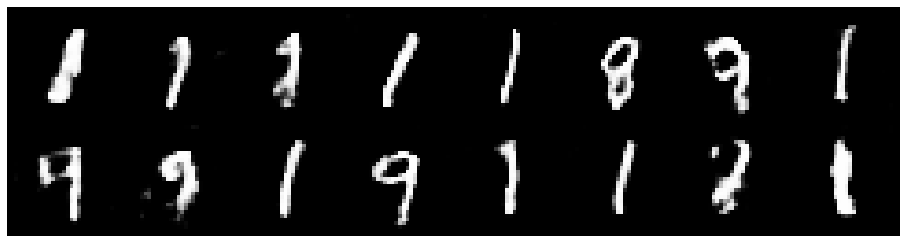

Epoch: [37/50], Batch Num: [0/600]
Discriminator Loss: 0.3261, Generator Loss: 3.3315
D(x): 0.9107, D(G(z)): 0.1383


Epoch: [38/50], Batch Num: [0/600]
Discriminator Loss: 0.2197, Generator Loss: 4.2786
D(x): 0.9227, D(G(z)): 0.0714


Epoch: [39/50], Batch Num: [0/600]
Discriminator Loss: 0.2495, Generator Loss: 5.5832
D(x): 0.8996, D(G(z)): 0.0339


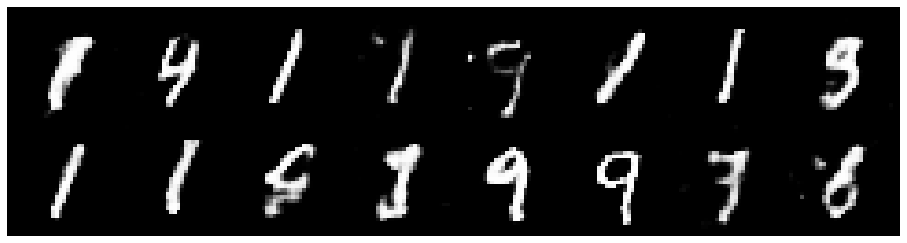

Epoch: [40/50], Batch Num: [0/600]
Discriminator Loss: 0.2530, Generator Loss: 3.9391
D(x): 0.9088, D(G(z)): 0.0790


Epoch: [41/50], Batch Num: [0/600]
Discriminator Loss: 0.2159, Generator Loss: 3.9869
D(x): 0.9644, D(G(z)): 0.1185


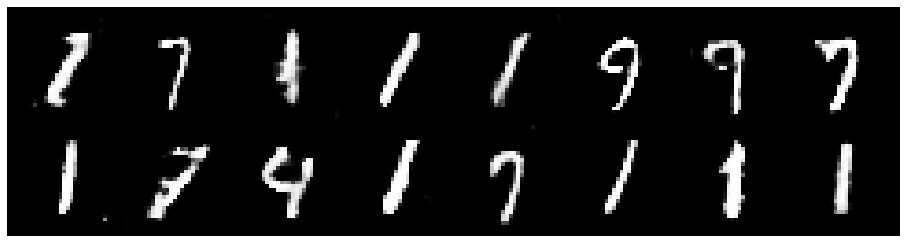

Epoch: [42/50], Batch Num: [0/600]
Discriminator Loss: 0.2428, Generator Loss: 4.6359
D(x): 0.9087, D(G(z)): 0.0506


Epoch: [43/50], Batch Num: [0/600]
Discriminator Loss: 0.2450, Generator Loss: 3.5637
D(x): 0.9329, D(G(z)): 0.1004


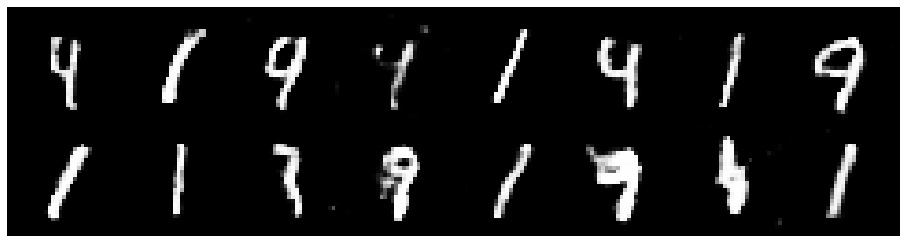

Epoch: [44/50], Batch Num: [0/600]
Discriminator Loss: 0.1626, Generator Loss: 4.1270
D(x): 0.9453, D(G(z)): 0.0792


Epoch: [45/50], Batch Num: [0/600]
Discriminator Loss: 0.3323, Generator Loss: 4.2786
D(x): 0.8910, D(G(z)): 0.1024


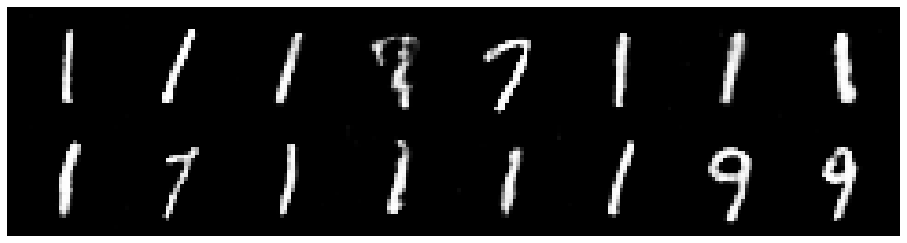

Epoch: [46/50], Batch Num: [0/600]
Discriminator Loss: 0.2468, Generator Loss: 4.2838
D(x): 0.9361, D(G(z)): 0.0983


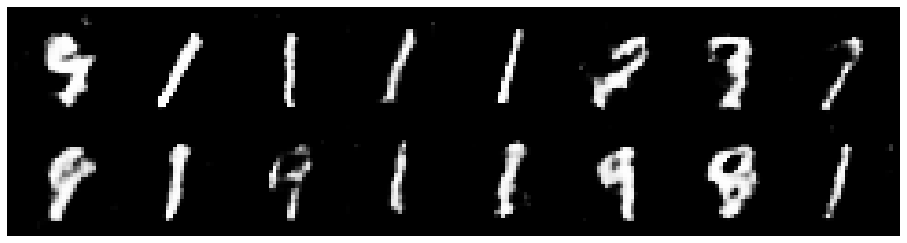

Epoch: [47/50], Batch Num: [0/600]
Discriminator Loss: 0.2427, Generator Loss: 3.8104
D(x): 0.9471, D(G(z)): 0.1310


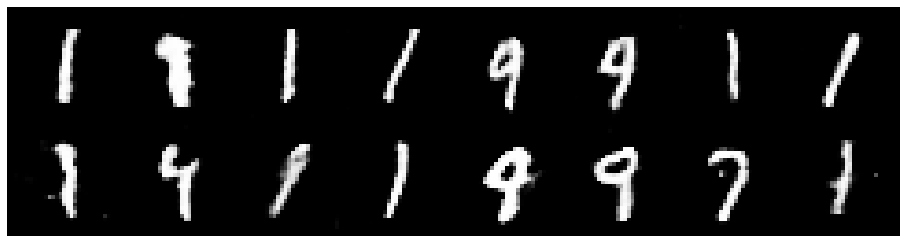

Epoch: [48/50], Batch Num: [0/600]
Discriminator Loss: 0.3218, Generator Loss: 4.0018
D(x): 0.9252, D(G(z)): 0.1048


Epoch: [49/50], Batch Num: [0/600]
Discriminator Loss: 0.2004, Generator Loss: 3.7887
D(x): 0.9307, D(G(z)): 0.0724


In [90]:
# Create logger instance
logger = Logger(model_name='Vannila_GAN', data_name='MNIST')# Total number of epochs to train

num_epochs = 50

for epoch in range(num_epochs):
    for n_batch, (real_batch,_) in enumerate(data_loader):
        batch_size = real_batch.size(0)        
        
        # Train D
        real_sample = Variable(real_batch)        
        G_sample = G(get_latent_sample(batch_size)).detach()        
        #explain the significance of detach in description
        d_loss, d_real_score, d_fake_score = train_D(D_optimizer, real_sample, G_sample)
        
        # Train G
        G_sample = G(get_latent_sample(batch_size))        
        g_loss = train_G(G_optimizer, G_sample)
        
        # Log things
        logger.log(d_loss, g_loss, epoch, n_batch, num_batches)        
        
        # Display Progress after some interval
        if ((n_batch) % 600 == 0): 
            test_images = G(get_latent_sample(num_test_samples))
            #show 16 images generated from G
            test_images = test_images.data            
            
            logger.log_images(
                test_images, num_test_samples, 
                epoch, n_batch, num_batches
            );
            # Display status Logs
            logger.display_status(
                epoch, num_epochs, n_batch, num_batches,
                d_loss, g_loss, d_real_score, d_fake_score
            )

Details regarding output of the training will be explained. Also, visualization of real mnist images below. Details will be added.

torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])


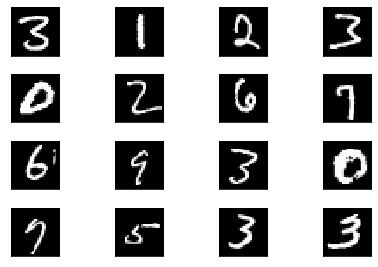

In [106]:
images, labels = next(iter(data_loader))
print(images.shape)
#plt.imshow(images[0].reshape(28,28), cmap="gray")

examples = enumerate(data_loader)
batch_idx, (example_data, example_targets) = next(examples)
print(example_data.shape)

import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(16):
  plt.subplot(4,4,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  #plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

**SRGAN**

Details of SRGAN, DIV2K Dataset

Let us see how a low resolution image in the dataset looks like:

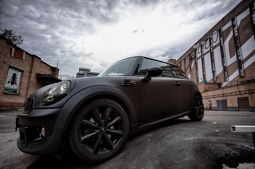

In [50]:
import torch as t
from torchvision.transforms import ToPILImage
from IPython.display import Image
to_img = ToPILImage()

# display tensor
a = t.Tensor(3, 64, 64).normal_()
to_img(a)

# display imagefile
Image('ondemand/sr_data/train_LR/DIV2K_train_LR_x8/0100x8.png')

And how its high resolution counterpart looks like:

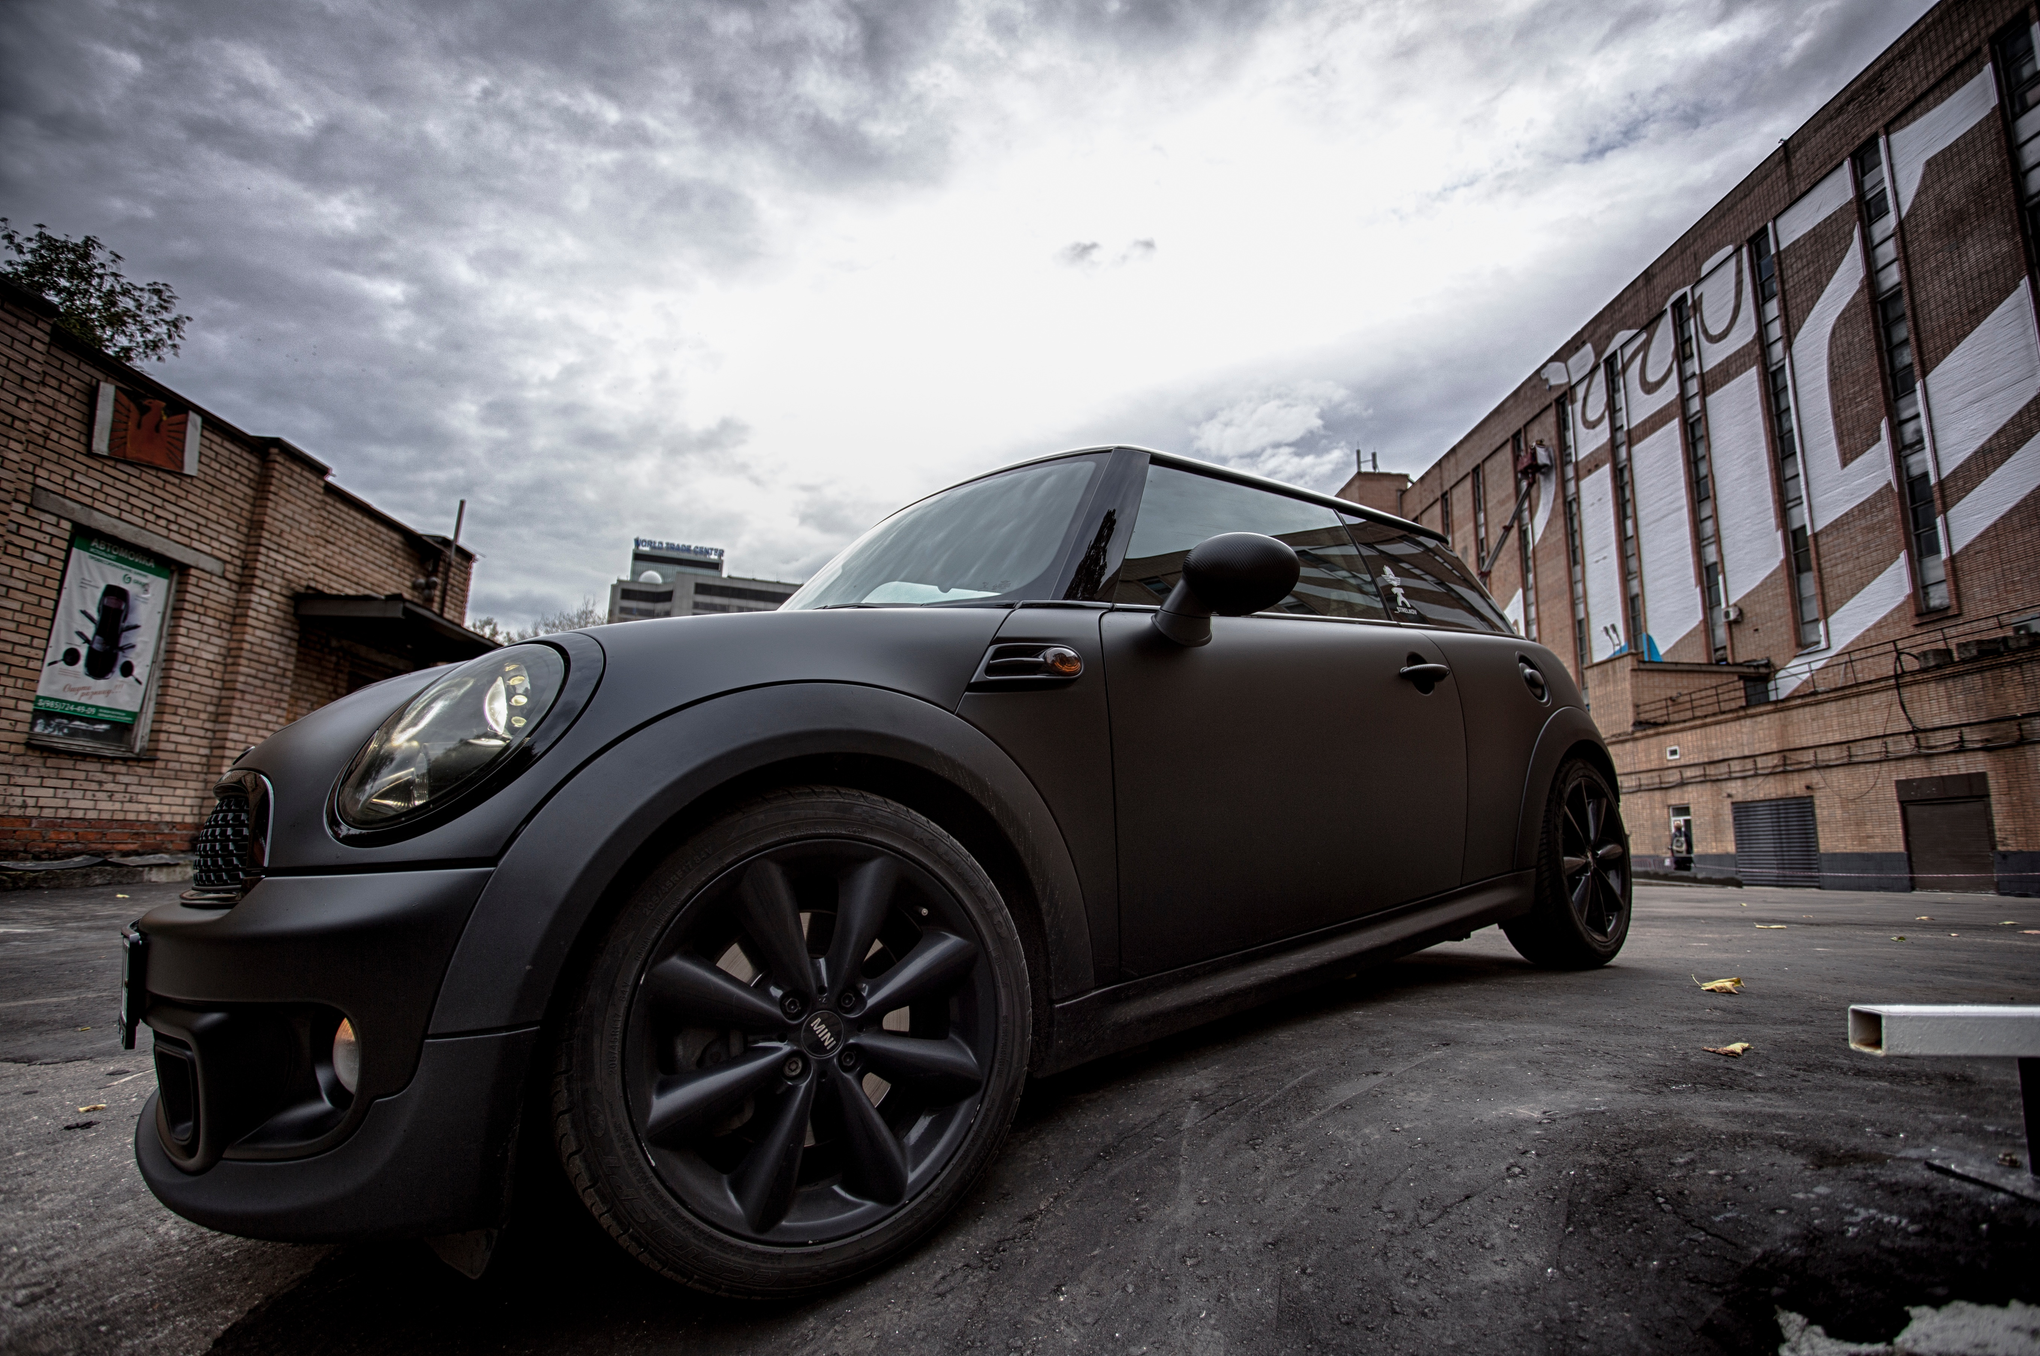

In [51]:
Image('ondemand/sr_data/train_HR/DIV2K_train_HR/0100.png')

Let us design a dataloader for this dataset first:

<class 'torchvision.datasets.folder.ImageFolder'>


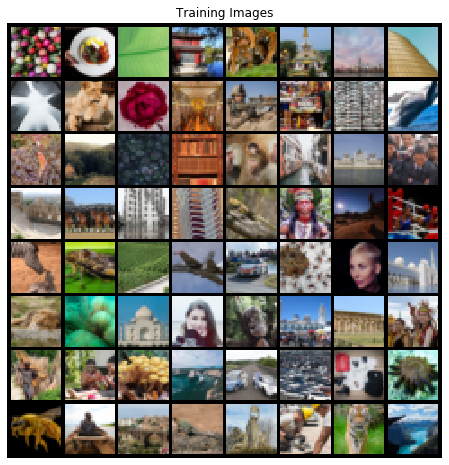

In [95]:
import torchvision.datasets as dset
import torchvision.utils as vutils

batch_size = 64
dataroot = 'ondemand/sr_data/train_LR/'
ngpu = 0

dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
print(type(dataset))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

This tutorial has been designed with help from the following websites:

a) https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

b) https://medium.com/ai-society/gans-from-scratch-1-a-deep-introduction-with-code-in-pytorch-and-tensorflow-cb03cdcdba0f